# Group 7
# ADS 504 Summer 2024

In [1]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the data

file_path = "/content/drive/MyDrive/ADS504/project/nvda_2018.csv"

#file_path = "/workspaces/ADS-504-02-Group-7-Machine-Learning-and-Deep-Learning-for-Data-Science/nvda_2018.csv"
data = pd.read_csv(file_path)

## TEST. Ensure data shows for given file_path. Comment out ones not unique to you.

In [4]:
data.head()

,time,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,...,ImpulseMACDCDSignal,RSI,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label
0,1510086600,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,5.30025,4.462440,...,0.057289,69.475334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1510151400,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,5.23525,4.464509,...,0.052901,51.395830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1510155000,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,5.23675,4.465430,...,0.045753,51.708145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1510158600,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,5.21825,4.466655,...,0.034023,47.642077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1510162200,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,5.20150,4.467462,...,0.022199,44.249339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature engineering.
### Convert original UNIX 'time' to datetime object

In [5]:
#Convert UNIX time to datetime object
data['time'] = pd.to_datetime(data['time'], unit='s')

### Add feature. Day of the week.

In [6]:
#Feature Engineering. Day of the week.
data['day_of_week'] = data['time'].dt.day_name()
data.insert(1, 'day_of_week', data.pop('day_of_week'))

### Convert from UTC time to America/New_York time (where NYSE trades)

In [7]:
#Convert to New York time (Where NYSE trades)
data['time'] = data['time'].dt.tz_localize('GMT')
data['time'] = data['time'].dt.tz_convert('America/New_York')

### Add feature. Morning / Afternoon categories.

In [8]:
#Feature Engineering. Morning/Afternoon
data['session'] = data['time'].dt.hour.apply(lambda x:
                                             'Morning' if x<12 else 'Afternoon')
data.insert(2, 'session', data.pop('session'))

### Add feature. Target = closing price = opening price

In [9]:
# Feature Engineering
data["target"] = data["close"] - data["open"]


### Add feature. Target_t+1 to be used as "forecasted" value. Use as model evaluation metric using RMSE. Penalize larger errors greater.

In [10]:
data["target_t+1"] = data["target"].shift(-1)


### Checkpoint. Post-Feature Engineering.

In [11]:
data.head()

,time,day_of_week,session,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),...,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label,target,target_t+1
0,2017-11-07 15:30:00-05:00,Tuesday,Afternoon,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01725,-0.05975
1,2017-11-08 09:30:00-05:00,Wednesday,Morning,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05975,0.00125
2,2017-11-08 10:30:00-05:00,Wednesday,Morning,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00125,-0.01775
3,2017-11-08 11:30:00-05:00,Wednesday,Morning,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01775,-0.01400
4,2017-11-08 12:30:00-05:00,Wednesday,Afternoon,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01400,0.00950


## EDA

### Explore cardinality and remove null or columns with no variation (1 or 0 cardinality)

In [12]:
cardinality = data.nunique()

# Remove columns with 1 or 0 cardinality
col_keep = cardinality[cardinality > 1].index
data = data[col_keep]
data.nunique()

,0
time,11751
day_of_week,5
session,2
open,10722
high,10554
low,10592
close,10605
PlotCandle (Open),10722
PlotCandle (High,10554
PlotCandle (Low),10592


## EDA. Visualization.

### Price

<Axes: >

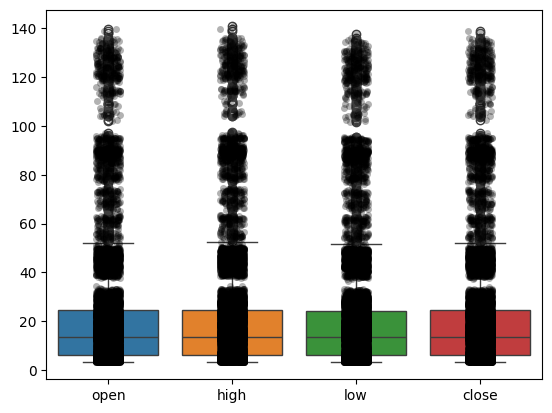

In [13]:
sns.boxplot(data = data[['open', 'high', 'low', 'close']])
sns.stripplot(data = data[['open', 'high', 'low', 'close']], jitter=True, color='black', alpha = 0.3)

Many outliers present in price. Should handle with appropriate method (clipping) to minimize affect on standard deviation and mean.

### Regular Bullish/Bearish Value Distribution

Text(0.5, 1.0, 'Regular Bullish vs Regular Bearish')

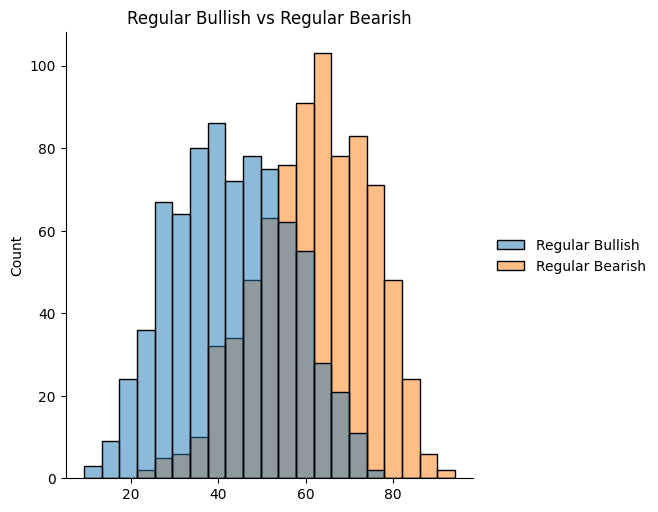

In [14]:
df = pd.DataFrame(data)
sns.displot(df[['Regular Bullish', 'Regular Bearish']])
plt.title('Regular Bullish vs Regular Bearish')

## Data Cleaning. Handle outliers with clipping.

In [15]:
num_cols = data.select_dtypes(include=[np.number])

Q1 = num_cols.quantile(.25)
Q3 = num_cols.quantile(.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

num_cols_clipped = num_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)
data = num_cols_clipped.join(data.drop(columns=num_cols.columns))

## Checkpoint. Post-Data Cleaning: Clipped.



In [16]:
data.head()

,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,Upper Band #1,...,Regular Bullish Label,Hidden Bullish,Regular Bearish,Regular Bearish Label,Hidden Bearish,target,target_t+1,time,day_of_week,session
0,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,5.30025,4.462440,4.817839,...,NaN,NaN,NaN,NaN,NaN,0.01725,-0.05975,2017-11-07 15:30:00-05:00,Tuesday,Afternoon
1,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,5.23525,4.464509,4.821719,...,NaN,NaN,NaN,NaN,NaN,-0.05975,0.00125,2017-11-08 09:30:00-05:00,Wednesday,Morning
2,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,5.23675,4.465430,4.823430,...,NaN,NaN,NaN,NaN,NaN,0.00125,-0.01775,2017-11-08 10:30:00-05:00,Wednesday,Morning
3,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,5.21825,4.466655,4.825640,...,NaN,NaN,NaN,NaN,NaN,-0.01775,-0.01400,2017-11-08 11:30:00-05:00,Wednesday,Morning
4,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,5.20150,4.467462,4.827079,...,NaN,NaN,NaN,NaN,NaN,-0.01400,0.00950,2017-11-08 12:30:00-05:00,Wednesday,Afternoon


### Plot boxplots of outlier-handled data

<Axes: >

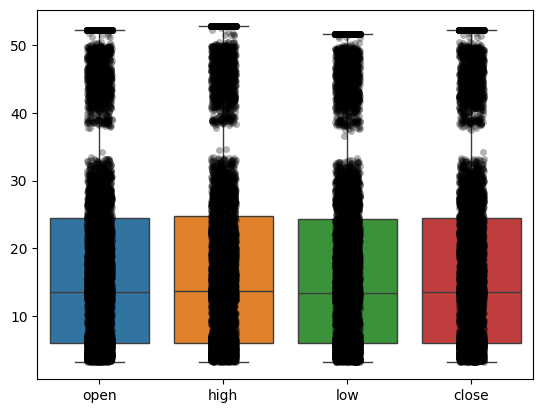

In [17]:
sns.boxplot(data = data[['open', 'high', 'low', 'close']])
sns.stripplot(data = data[['open', 'high', 'low', 'close']], jitter=True, color='black', alpha = 0.3)

In [18]:
data.describe()

,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,Upper Band #1,...,ImpulseMACDCDSignal,RSI,Regular Bullish,Regular Bullish Label,Hidden Bullish,Regular Bearish,Regular Bearish Label,Hidden Bearish,target,target_t+1
count,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,...,11751.000000,11751.000000,773.000000,47.000000,773.000000,782.000000,109.000000,782.000000,11751.000000,11750.000000
mean,18.521895,18.655232,18.388390,18.523754,18.521895,18.655232,18.388390,18.523754,18.211374,19.380870,...,0.050324,52.770201,43.045584,31.902592,43.045584,62.113744,69.486574,62.113744,0.002949,0.002946
std,15.407151,15.540164,15.276932,15.408749,15.407151,15.540164,15.276932,15.408749,15.112916,16.240988,...,0.231509,13.969243,13.221043,6.096085,13.221043,12.638289,6.544558,12.638289,0.111392,0.111417
min,3.141750,3.150750,3.113500,3.141250,3.141750,3.150750,3.113500,3.141250,3.631566,3.809856,...,-0.359548,12.378961,9.412335,18.297603,9.412335,26.616331,52.464690,26.616331,-0.205781,-0.205859
25%,6.033375,6.057000,5.997562,6.032375,6.033375,6.057000,5.997562,6.032375,5.972547,6.194836,...,-0.048948,42.734248,33.100232,27.723527,33.100232,53.625506,65.183786,53.625506,-0.049313,-0.049344
50%,13.536000,13.604250,13.449000,13.532000,13.536000,13.604250,13.449000,13.532000,13.272913,13.803004,...,0.004333,53.183313,42.593023,32.480574,42.593023,62.786525,69.126650,62.786525,0.001250,0.001250
75%,24.505000,24.743000,24.267500,24.508500,24.505000,24.743000,24.267500,24.508500,23.953340,26.118768,...,0.158118,62.971106,52.825179,35.909946,52.825179,71.631623,73.663184,71.631623,0.055000,0.055000
max,52.212438,52.772000,51.672406,52.222687,52.212438,52.772000,51.672406,52.222687,50.924529,56.004666,...,0.468717,93.326393,77.615040,48.189576,77.615040,94.098040,85.971551,94.098040,0.211469,0.211516


## Data Cleaning. Handle missing values.

In [19]:
# Use forward fill as it is logical for previous known value to carry forward
data.fillna(method="ffill", inplace=True)

<ipython-input-19-ee18d535629b>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


In [20]:
# Correct column names
correct_column_names = [
    "time",
    "day_of_week",
    "session",
    "open",
    "high",
    "low",
    "close",
    "PlotCandle (Open)",
    "PlotCandle (High)",
    "PlotCandle (Low)",
    "PlotCandle (Close)",
    "VWAP",
    "Upper Band #1",
    "Lower Band #1",
    "Upper Band #2",
    "Lower Band #2",
    "Upper Band #3",
    "Lower Band #3",
    "MidLine",
    "ImpulseMACD",
    "ImpulseHisto",
    "ImpulseMACDSignal",
    "RSI",
    "Regular Bullish Label",
    "Regular Bullish",
    "Hidden Bullish Label",
    "Hidden Bullish",
    "Regular Bearish Label",
    "Regular Bearish",
    "Hidden Bearish Label",
    "Hidden Bearish",
]

In [21]:
# Lag Features
for lag in range(1, 4):
    data[f"close_lag_{lag}"] = data["close"].shift(lag)

# Rolling Statistics
data["close_rolling_mean_5"] = data["close"].rolling(window=5).mean()
data["close_rolling_std_5"] = data["close"].rolling(window=5).std()

In [22]:
data.columns

Index(['open', 'high', 'low', 'close', 'PlotCandle (Open)', 'PlotCandle (High',
       'PlotCandle (Low)', 'PlotCandle (Close)', 'VWAP', 'Upper Band #1',
       'Lower Band #1', 'Upper Band #2', 'Lower Band #2', 'Upper Band #3',
       'Lower Band #3', 'ImpulseMACD', 'ImpulseHisto', 'ImpulseMACDCDSignal',
       'RSI', 'Regular Bullish', 'Regular Bullish Label', 'Hidden Bullish',
       'Regular Bearish', 'Regular Bearish Label', 'Hidden Bearish', 'target',
       'target_t+1', 'time', 'day_of_week', 'session', 'close_lag_1',
       'close_lag_2', 'close_lag_3', 'close_rolling_mean_5',
       'close_rolling_std_5'],
      dtype='object')

In [23]:
# Drop unused columns
columns_to_drop = [
    "Regular Bullish",
    "Regular Bullish Label",
    "Hidden Bullish",
    "Regular Bearish",
    "Regular Bearish Label",
    "Hidden Bearish",
]
data.drop(columns=columns_to_drop, inplace=True)

# Convert categorical features to numerical
data = pd.get_dummies(
    data, columns=["day_of_week", "session"], drop_first=True
)

# Create the target variable: close - open
data["target"] = data["close"] - data["open"]
data["target_t+1"] = data["target"].shift(-1)

# Handle NaN introduced by the shift
data.dropna(subset=["target_t+1"], inplace=True)

# Extract features and target variable
X = data.drop(columns=["time", "close", "target", "target_t+1"])
y = data["target_t+1"]

In [24]:
from sklearn.impute import SimpleImputer

# Ensure alignment of X and y
X = X.iloc[:-1]
y = y.iloc[:-1]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
}

random_search_xgb = RandomizedSearchCV(
    xgb_model, param_grid_xgb, n_iter=10, cv=3, scoring="r2", n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Assuming X_train_scaled, X_test_scaled, y_train, y_test, and random_search_xgb are already defined

# Initialize models
lr_model = LinearRegression()
best_rf_model = RandomForestRegressor(random_state=42)
best_xgb_model = xgb.XGBRegressor(**random_search_xgb.best_params_)

# Train models
lr_model.fit(X_train_scaled, y_train)
best_rf_model.fit(X_train_scaled, y_train)
best_xgb_model.fit(X_train_scaled, y_train)

# Evaluate models
lr_predictions = lr_model.predict(X_test_scaled)
rf_predictions = best_rf_model.predict(X_test_scaled)
xgb_predictions = best_xgb_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"Linear Regression MSE: {lr_mse}, R2: {lr_r2}")
print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")
print(f"Best XGBoost Parameters: {random_search_xgb.best_params_}")

# Cross-Validation Scores
cv_scores_xgb = cross_val_score(
    best_xgb_model, X_train_scaled, y_train, cv=5, scoring="r2", n_jobs=-1
)
print(f"XGBoost 5-fold CV R2: {np.mean(cv_scores_xgb)}")

Linear Regression MSE: 0.03266695492983303, R2: -0.024921559034823515
Random Forest MSE: 0.0344291357316553, R2: -0.08020975772320216
XGBoost MSE: 0.03201285435032616, R2: -0.004399236487351743
Best XGBoost Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}
XGBoost 5-fold CV R2: -0.0020804249196019866
